# 프로젝트 : 네이버 영화리뷰 감성분석 도전하기


**오늘 활용할 데이터셋은 네이버 영화의 댓글을 모아 구성된 Naver sentiment movie corpus이다**

In [11]:
! ln -s ~/data/*.txt ~/aiffel/sentiment_classification/data

ln: failed to create symbolic link '/aiffel/aiffel/sentiment_classification/data/ratings_test.txt': File exists
ln: failed to create symbolic link '/aiffel/aiffel/sentiment_classification/data/ratings_train.txt': File exists


## 1. 데이터 준비와 확인

In [12]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [13]:
print(train_data.shape, test_data.shape)

(150000, 3) (50000, 3)


## 2.  데이터로더 구성

- IMDB 데이터셋은 텍스트를 가공하여 imdb.data_loader() 메소드를 호출하면 숫자 인덱스로 변환된 텍스트 word_to_index 딕셔너리까지 친절하게 제공한다. 
- 이번에 다루게 될 nsmc 데이터셋은 전혀 가공되지 않은 텍스트 파일로 이루어져 있다.
- 이것을 읽어서 imdb.data_loader()와 동일하게 동작하는 자신만의 data_loader를 만들어 보는 것으로 시작한다.
- data_loader 안에서는 다음을 수행해야 한다. 

- 데이터의 중복 제거
- NaN 결측치 제거
- 한국어 토크나이저로 토큰화
- 불용어(Stopwords) 제거
- 사전word_to_index 구성
- 텍스트 스트링을 사전 인덱스 스트링으로 변환
- X_train, y_train, X_test, y_test, word_to_index 리턴

In [14]:
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(10000-4)
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data) 

print("훈련 개수: {}, 테스트 개수: {}".format(len(X_train), len(X_test)))

훈련 개수: 146182, 테스트 개수: 49157


In [15]:
index_to_word = {index:word for word, index in word_to_index.items()}
print(index_to_word)

{0: '<PAD>', 1: '<BOS>', 2: '<UNK>', 3: '<UNUSED>', 4: '.', 5: '영화', 6: '다', 7: '고', 8: '하', 9: '을', 10: '보', 11: '..', 12: '게', 13: ',', 14: '!', 15: '지', 16: '있', 17: '없', 18: '?', 19: '좋', 20: '나', 21: '었', 22: '만', 23: '는데', 24: '너무', 25: '봤', 26: '적', 27: '안', 28: '정말', 29: '로', 30: '음', 31: '것', 32: '아', 33: '네요', 34: '재밌', 35: '어', 36: '같', 37: '점', 38: '지만', 39: '진짜', 40: '했', 41: '에서', 42: '기', 43: '네', 44: '않', 45: '거', 46: '았', 47: '수', 48: '되', 49: '면', 50: 'ㅋㅋ', 51: '말', 52: '연기', 53: '인', 54: '주', 55: '내', 56: '최고', 57: '~', 58: '평점', 59: '이런', 60: '던', 61: '어요', 62: '할', 63: '왜', 64: '겠', 65: '1', 66: '스토리', 67: '해', 68: '습니다', 69: 'ㅋㅋㅋ', 70: '...', 71: '드라마', 72: '생각', 73: '아니', 74: '더', 75: '그', 76: '싶', 77: '사람', 78: '듯', 79: '때', 80: '감동', 81: '함', 82: '배우', 83: '본', 84: '까지', 85: '뭐', 86: '알', 87: '만들', 88: '내용', 89: '볼', 90: '감독', 91: '보다', 92: '라', 93: '그냥', 94: '재미', 95: '시간', 96: '지루', 97: '중', 98: '재미있', 99: '년', 100: '10', 101: '였', 102: '잼', 103: '사랑', 104: '

In [16]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

## 3. 모델구성을 위한 데이터 분석 및 가공

**아래 나열 순으로 정리**

- 데이터셋 내 문장 길이 분포
- 적절한 최대 문장 길이 지정
- keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

### 1) 데이터셋 내 문장 길이 분포

In [17]:
# 다운받은 데이터 실제 예시 확인
print(X_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

[32, 74, 919, 4, 4, 39, 228, 20, 33, 748]
라벨:  0
1번째 리뷰 문장 길이:  10
2번째 리뷰 문장 길이:  17


### 2) 적절한 최대 문장 길이 지정

In [18]:
# x_train과 x_test를 합치기
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}%가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  15.96940191154864
문장길이 최대 :  116
문장길이 표준편차 :  12.843571191092
pad_sequences maxlen :  41
전체 문장의 0.9342988343341575%가 maxlen 설정값 이내에 포함됩니다. 


### 3) 패딩 추가

In [19]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)

X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)
print(X_test.shape)

(146182, 41)
(49157, 41)


## 4. 모델구성 및 validation set 구성

- 모델은 3가지 이상 다양하게 구성하여 실험

In [28]:
print(X_train.shape)
print(y_train.shape)

(146182, 41)
(146182,)


In [29]:
# validation set 20000건 분리
x_val = X_train[:20000]   
y_val = y_train[:20000]

# validation set을 제외한 나머지 15000건
partial_X_train = X_train[20000:]  
partial_y_train = y_train[20000:]

print(partial_X_train.shape)
print(partial_y_train.shape)

(126182, 41)
(126182,)


### 1) RNN

In [69]:
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 30  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

# model 설계 - 딥러닝 모델 코드를 직접 작성해 주세요.

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.MaxPooling1D(5))
model.add(keras.layers.Conv1D(16, 7, activation='relu'))
model.add(keras.layers.GlobalMaxPooling1D())
model.add(keras.layers.Dense(8, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.


model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, None, 30)          300000    
_________________________________________________________________
conv1d_8 (Conv1D)            (None, None, 16)          3376      
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, None, 16)          0         
_________________________________________________________________
conv1d_9 (Conv1D)            (None, None, 16)          1808      
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 16)                0         
_________________________________________________________________
dense_18 (Dense)             (None, 8)                 136       
_________________________________________________________________
dense_19 (Dense)             (None, 1)                

### 2) LSTM

In [82]:
# LSTM
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 30  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model2 = keras.Sequential()
model2.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model2.add(keras.layers.LSTM(8))   # 가장 널리 쓰이는 RNN인 LSTM 레이어를 사용하였습니다. 이때 LSTM state 벡터의 차원수는 8로 하였습니다. (변경 가능)
model2.add(keras.layers.Dense(8, activation='relu'))
model2.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model2.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, None, 30)          300000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 8)                 1248      
_________________________________________________________________
dense_24 (Dense)             (None, 8)                 72        
_________________________________________________________________
dense_25 (Dense)             (None, 1)                 9         
Total params: 301,329
Trainable params: 301,329
Non-trainable params: 0
_________________________________________________________________


### 3) GlobalMaxPooling

In [83]:
# GlobalMaxPooling
vocab_size = 10000    # 어휘 사전의 크기입니다(10,000개의 단어)
word_vector_dim = 30  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

model3 = keras.Sequential()
model3.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model3.add(keras.layers.GlobalMaxPooling1D())
model3.add(keras.layers.Dense(8, activation='relu'))
model3.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model3.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, None, 30)          300000    
_________________________________________________________________
global_max_pooling1d_9 (Glob (None, 30)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 8)                 248       
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 9         
Total params: 300,257
Trainable params: 300,257
Non-trainable params: 0
_________________________________________________________________


## 5. 모델 훈련 개시 및  Loss, Accuracy 그래프 시각화

### 1) RNN

In [84]:
model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
            
epochs=10

history = model.fit(partial_X_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=512,
                   validation_data=(x_val, y_val),
                   verbose=1)

Epoch 1/10
247/247 [==============================] - 3s 9ms/step - loss: 0.0554 - accuracy: 0.9836 - val_loss: 0.6414 - val_accuracy: 0.8320
Epoch 2/10
247/247 [==============================] - 2s 8ms/step - loss: 0.0431 - accuracy: 0.9873 - val_loss: 0.6975 - val_accuracy: 0.8278
Epoch 3/10
247/247 [==============================] - 2s 8ms/step - loss: 0.0368 - accuracy: 0.9894 - val_loss: 0.7569 - val_accuracy: 0.8249
Epoch 4/10
247/247 [==============================] - 2s 8ms/step - loss: 0.0318 - accuracy: 0.9905 - val_loss: 0.8163 - val_accuracy: 0.8235
Epoch 5/10
247/247 [==============================] - 2s 8ms/step - loss: 0.0282 - accuracy: 0.9914 - val_loss: 0.8899 - val_accuracy: 0.8203
Epoch 6/10
247/247 [==============================] - 2s 8ms/step - loss: 0.0267 - accuracy: 0.9918 - val_loss: 0.9427 - val_accuracy: 0.8202
Epoch 7/10
247/247 [==============================] - 2s 8ms/step - loss: 0.0248 - accuracy: 0.9922 - val_loss: 0.9976 - val_accuracy: 0.8195
Epoch 

In [85]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 1.1079 - accuracy: 0.8189
[1.1078779697418213, 0.8189067840576172]


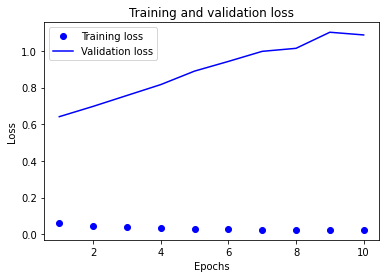

In [86]:
import matplotlib.pyplot as plt

history_dict = history.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

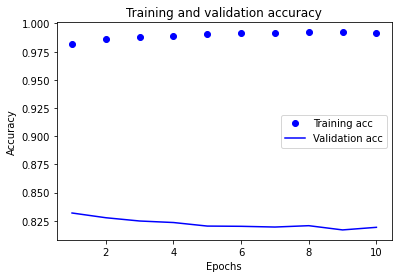

In [87]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 2) LSTM

In [88]:
model2.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
            
epochs=10

history2 = model2.fit(partial_X_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=512,
                   validation_data=(x_val, y_val),
                   verbose=1)

Epoch 1/10
247/247 [==============================] - 5s 12ms/step - loss: 0.6123 - accuracy: 0.6353 - val_loss: 0.3678 - val_accuracy: 0.8445
Epoch 2/10
247/247 [==============================] - 3s 11ms/step - loss: 0.3421 - accuracy: 0.8579 - val_loss: 0.3449 - val_accuracy: 0.8489
Epoch 3/10
247/247 [==============================] - 3s 11ms/step - loss: 0.3076 - accuracy: 0.8731 - val_loss: 0.3482 - val_accuracy: 0.8523
Epoch 4/10
247/247 [==============================] - 3s 11ms/step - loss: 0.2933 - accuracy: 0.8771 - val_loss: 0.3516 - val_accuracy: 0.8498
Epoch 5/10
247/247 [==============================] - 3s 11ms/step - loss: 0.2834 - accuracy: 0.8797 - val_loss: 0.3544 - val_accuracy: 0.8494
Epoch 6/10
247/247 [==============================] - 3s 11ms/step - loss: 0.2677 - accuracy: 0.8839 - val_loss: 0.3618 - val_accuracy: 0.8519
Epoch 7/10
247/247 [==============================] - 3s 11ms/step - loss: 0.2546 - accuracy: 0.8900 - val_loss: 0.3686 - val_accuracy: 0.8444

In [89]:
results = model2.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 5s - loss: 0.4036 - accuracy: 0.8496
[0.4036449193954468, 0.8496450185775757]


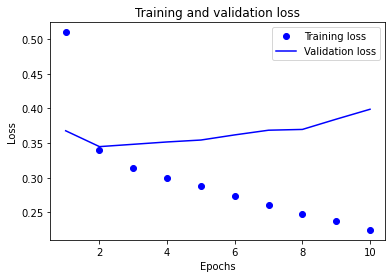

In [90]:
history_dict = history2.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

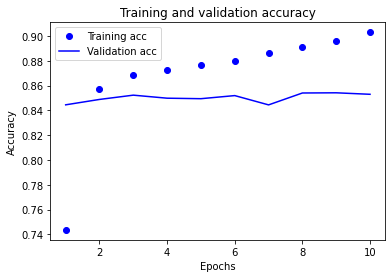

In [91]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

### 3) GlobalMaxPooling

In [92]:
model3.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
            
epochs=10

history3 = model3.fit(partial_X_train,
                   partial_y_train,
                   epochs=epochs,
                   batch_size=512,
                   validation_data=(x_val, y_val),
                   verbose=1)

Epoch 1/10
247/247 [==============================] - 2s 6ms/step - loss: 0.6353 - accuracy: 0.7006 - val_loss: 0.3954 - val_accuracy: 0.8317
Epoch 2/10
247/247 [==============================] - 1s 5ms/step - loss: 0.3647 - accuracy: 0.8471 - val_loss: 0.3474 - val_accuracy: 0.8475
Epoch 3/10
247/247 [==============================] - 1s 5ms/step - loss: 0.3065 - accuracy: 0.8729 - val_loss: 0.3419 - val_accuracy: 0.8503
Epoch 4/10
247/247 [==============================] - 1s 5ms/step - loss: 0.2753 - accuracy: 0.8883 - val_loss: 0.3446 - val_accuracy: 0.8518
Epoch 5/10
247/247 [==============================] - 1s 5ms/step - loss: 0.2480 - accuracy: 0.9015 - val_loss: 0.3530 - val_accuracy: 0.8519
Epoch 6/10
247/247 [==============================] - 1s 5ms/step - loss: 0.2273 - accuracy: 0.9110 - val_loss: 0.3640 - val_accuracy: 0.8503
Epoch 7/10
247/247 [==============================] - 1s 5ms/step - loss: 0.2087 - accuracy: 0.9197 - val_loss: 0.3804 - val_accuracy: 0.8471
Epoch 

In [95]:
results = model3.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.4435 - accuracy: 0.8383
[0.4435136914253235, 0.838273286819458]


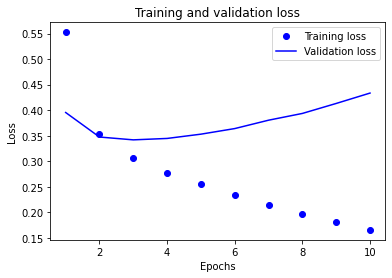

In [96]:
history_dict = history3.history
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

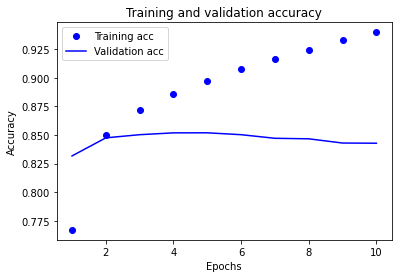

In [97]:
plt.clf()   # 그림을 초기화합니다

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## 6.학습된 Embedding 레이어 분석

In [98]:
embedding_layer = model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(10000, 30)


In [114]:
import os

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [129]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
word_vectors.similar_by_word("미안")

[('박차', 0.6628071069717407),
 ('갓파더', 0.659773051738739),
 ('관람객', 0.6359308958053589),
 ('김사랑', 0.6284210085868835),
 ('김신', 0.6272549033164978),
 ('종이', 0.6236286759376526),
 ('보인다', 0.6212613582611084),
 ('썩', 0.6209102272987366),
 ('버틸', 0.6180155873298645),
 ('반면', 0.6179236173629761)]

In [130]:
word_vectors.similar_by_word("소리")

[('연속극', 0.7038866877555847),
 ('습격', 0.6870965957641602),
 ('인가요', 0.6639782786369324),
 ('..;;', 0.6616928577423096),
 ('죽여도', 0.6532237529754639),
 ('마리오', 0.6492257118225098),
 ('서바이벌', 0.6454441547393799),
 ('힙', 0.6401879191398621),
 ('기승', 0.6330857872962952),
 ('그다지', 0.622279942035675)]

In [131]:
word_vectors.similar_by_word("안녕")

[('~!!!!', 0.7309830188751221),
 ('광수', 0.7061614394187927),
 ('재수없', 0.6758206486701965),
 ('워스트', 0.6346253752708435),
 ('조로리', 0.6288608908653259),
 ('어설펐', 0.6238418221473694),
 ('수년', 0.6155343651771545),
 ('안중근', 0.6129555106163025),
 ('세기', 0.5979865193367004),
 ('졸립', 0.5908721685409546)]

## 7. 한국어 Word2Vec 임베딩 활용하여 성능개선

https://github.com/Kyubyong/wordvectors

- 파일을 다운로드 했지만 뭐가 맞지 않는지 실행이 되지 않았다.
- 원인을 찾지 못했다..... 

## 8. 회고

**의문과 궁금한 것**
- 모델들의 차이점에 대해서 인지를 못하다 보니, 어떤 모델을 어떻게 써야하는지 이해가 가지 않은 부분이 있었다.
- 모델학습을 하고 실행 시킬 때마다 Loss, Accuracy 값이 계속 달라져서 어떤 것이 정확한지 그리고 뭐가 맞는지 잘 모르겠다.
- 마지막에 한국어 Word2Vec이 실행이 되지 않아서 아쉬움이 남는다. 파일 설정을 어떻게 해야되는지 알아 봐야 될거 같다.

**정리**
1. 모델의 차이점 파악하기
2. 모델의 성능을 좋게 하기 위해서 어떻게 값을 조절해야하는지 알아보기
3. Word2Vec할 때 파일 설정을 어떻게 하면 되는지 알아보기